#### **MSc Data Science and AI for Creative Industries Thesis Project** 
# AI Concept Art Generator Finetuning

This notebook contains code that was used for fine-tuning a stable diffusion model to generate "concept art" from sample images of existing characters from anime and video games such as vocaloid, Genshin Impact, Hyperdimension Neptunia, etc. Due to GPU limitations, I opted for the LoRA (Low Rank Adaptation of Large Language Models) technique - this means that finetuning stable diffusion models would only require a few images and can be carried out on lower end GPUs. Please check out [this Huggingface blog post](https://huggingface.co/blog/lora) for more information on LoRA.

The finetuning process is carried out with Huggingface's [Diffusers](https://github.com/huggingface/diffusers/tree/main/examples/text_to_image) git repository.

You can utilise this notebook as a template if you would like to finetune a model to fit your own images. Please note that, for easier use, you may want to have a HuggingFace account in order to use the models and datasets involved.

Training was carried out using a P5000 using the Paperspace Gradient platform.

## Step 1: Set up Diffusers environment

Comment out install commands if the libraries or repositories are not available on your local machine.

In [1]:
# Install libraries

%pip install torch
%pip install accelerate

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 24.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Install Diffusers git repository

#!git clone https://github.com/huggingface/diffusers
%cd diffusers
%pip install .
%cd /notebooks/diffusers/examples/text_to_image
%pip install -r requirements.txt

/notebooks/diffusers
Processing /notebooks/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.9 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.20.0.dev0-py3-none-any.whl size=1325390 sha256=fd5b9f22087da2385dd2490fb442f16a04a04ae8e3b638f9ac14e3f82172d263
  Stored in directory: /tmp/pip-ephem-wheel-cache-7jt93y78/wheels/fb/af/d9/9b50d5f6645a3d2a02d9c27e020c96517682310458aaffd7bf
Successfully built diffusers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.12.0
    Uninstalling huggingface-hub-0.12.0:
      Successfully uninstalled huggingface-hub-0.12.0
Note: you may need to restart the kernel to use updated packages.
/notebooks/diffusers/examples/text_to_image
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
!accelerate config default

accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


### Setting up logins

As previously stated, in order to properly use the model and dataset, you may need to have a Hugginface account (it is also easier to store your finetuned model to the Hub for easier use and reference).

In addition, installing **wandb** (Weights and Biases) to track the loss and other statistics of the finetuning process. 

In [5]:
%pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [6]:
%env WANDB_API_KEY=9ab62cacb526909ba429782bb9455baf81e2f8ae
!wandb login

env: WANDB_API_KEY=9ab62cacb526909ba429782bb9455baf81e2f8ae
wandb: Currently logged in as: tcelulade22. Use `wandb login --relogin` to force relogin


In [4]:
#Log into Huggingface to access models and saving abilities
from huggingface_hub import interpreter_login

interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [6]:
#Check the GPU(s) used for the training
!nvidia-smi -L

GPU 0: Quadro P5000 (UUID: GPU-51589eb5-dd23-d614-d483-fbc07cc7dcb1)


## STEP 2: Build and carry out finetuning code

Now we can begin the process of finetuning. The base model that we will be finetuning is CompVis' stable diffusion model (specifically v1-4) and the finetuning will be carried out on a custom text-2-image dataset I made with anime characetrs and corresponding captions. You can access this dataset [here](https://huggingface.co/datasets/Christabelle/ai_anime_character_inspo) but you are more than free to use your own.

During training, we give the model a validation prompt to see how well the model is adapting to the dataset.

In [ ]:
#Depending on your preference, you may set the necessary inputs as vriables,
#I chose to personally avoid this due to issues with performance.

!export MODEL_NAME="CompVis/stable-diffusion-v1-4"
!export DATASET_NAME="Christabelle/ai_anime_character_inspo"
!export OUTPUT_DIR="sd-anime-model-lora"
!export HUB_MODEL_ID="sd_anime_concept_generator" #This is the name that the model will be saved as on the Huggingface Hub

In [8]:
!accelerate launch --mixed_precision="fp16" train_text_to_image_lora.py --pretrained_model_name_or_path="CompVis/stable-diffusion-v1-4"  --dataset_name="Christabelle/ai_anime_character_inspo" --caption_column="text"  --resolution=512 --random_flip  --train_batch_size=2  --num_train_epochs=100 --checkpointing_steps=5000  --learning_rate=1e-04 --lr_scheduler="constant" --lr_warmup_steps=0  --seed=42  --output_dir="sd-anime-model-lora" --push_to_hub   --hub_model_id="sd_anime_concept_generator"  --validation_prompt="a girl in a school uniform" --report_to="wandb" 

08/08/2023 11:01:00 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

{'clip_sample_range', 'variance_type', 'sample_max_value', 'thresholding', 'timestep_spacing', 'prediction_type', 'dynamic_thresholding_ratio'} was not found in config. Values will be initialized to default values.
{'norm_num_groups', 'force_upcast'} was not found in config. Values will be initialized to default values.
{'transformer_layers_per_block', 'class_embed_type', 'time_cond_proj_dim', 'addition_time_embed_dim', 'use_linear_projection', 'resnet_skip_time_act', 'num_attention_heads', 'timestep_post_act', 'class_embeddings_concat', 'conv_out_kernel', 'encoder_hid_dim', 'conv_in_kernel', 'time_embedding_act_fn', 'addition_embed_type', 'time_embedding_type', 'num_class_embeds', 'mid_block_only_cross_attention', 'mid_block_type', 'encoder_hid_dim_type', 'time_embedding_dim', 'resnet_time_scale_shift', 'dual_cross_atten

## STEP 3: Inference

With the model now finetuned, we can now carry out inference. Note that, with the way that the diffuser library's NSFW checker is set up, the model has the tend to output a black image. Code has been added to the inference code to disable it.

In [1]:
from huggingface_hub import model_info

# LoRA weights ~3 MB
model_path = "Christabelle/sd_anime_concept_generator"

info = model_info(model_path)
model_base = info.cardData["base_model"]
print(model_base)

CompVis/stable-diffusion-v1-4


In [2]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler, UniPCMultistepScheduler

pipe = StableDiffusionPipeline.from_pretrained(model_base, torch_dtype=torch.float16)
#pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config) #using this scheduler is faster

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/250 [00:00<?, ?it/s]

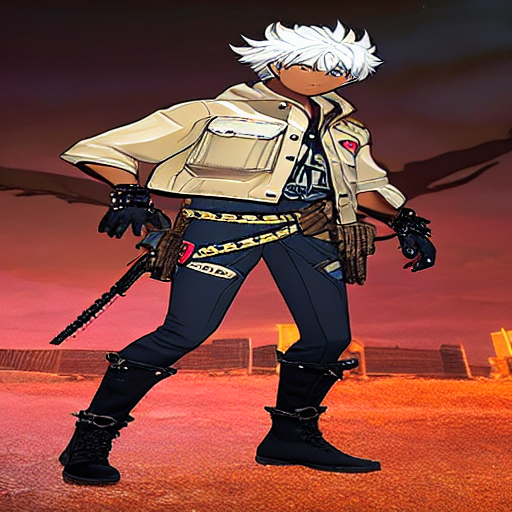

In [12]:
from PIL import Image

pipe.unet.load_attn_procs(model_path)
pipe.to("cuda")

# Code adapted from:
# https://www.reddit.com/r/StableDiffusion/comments/wxba44/comment/ilqa7an/?utm_source=share&utm_medium=web2x&context=3
pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

prompt = "a man in a hunter outfit, white hair, dark skin, tan skin, red eyes, punk motif"
image = pipe(prompt, negative_prompt="monochrome,low res,poorly drawn face, mutated body parts, deformed body features, bad anatomy, worst quality, low quality",num_inference_steps=250).images[0]
image.save("magician.png")
image.show()

It is also possibly to create multiple images at once with this model.

In [94]:
# Gives multiple images
# Code from: 
# https://colab.research.google.com/github/LambdaLabsML/lambda-diffusers/blob/main/notebooks/pokemon_demo.ipynb#scrollTo=so1GmFN0q_M4

from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/250 [00:00<?, ?it/s]

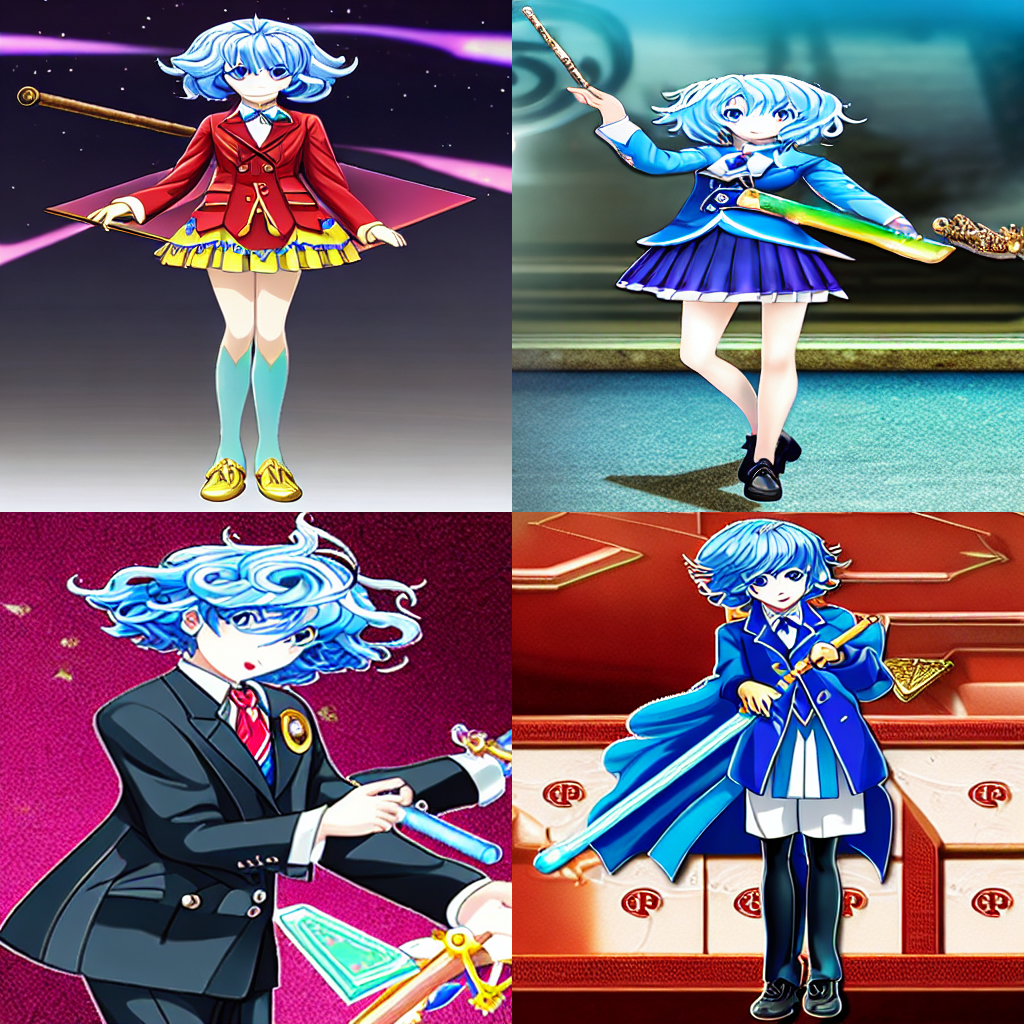

In [107]:
from torch import autocast

prompt = "a man or woman in a school uniform, moon motif, magician, blue hair, mint hair, holding a staff"
scale = 7.5
n_samples = 4

pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

with autocast("cuda"):
  images = pipe(n_samples*[prompt], negative_prompt=n_samples*["monochrome,low res,poorly drawn face, mutated body parts, deformed body features, bad anatomy, worst quality, low quality"],guidance_scale=scale,num_inference_steps=250).images

grid = image_grid(images, rows=2, cols=2)
grid

You can also use this generative AI system to see how the generated design would look on a simple charater model. You can use the character models from [this dataset](https://huggingface.co/datasets/Christabelle/AI-Thesis-Sketch-Skeletons) to try and create characters from a variety of skin tones or use your own sketches (preferably, have the images hosted on a publically accessible url).

This step is done using Image-2-image implementation.

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/225 [00:00<?, ?it/s]

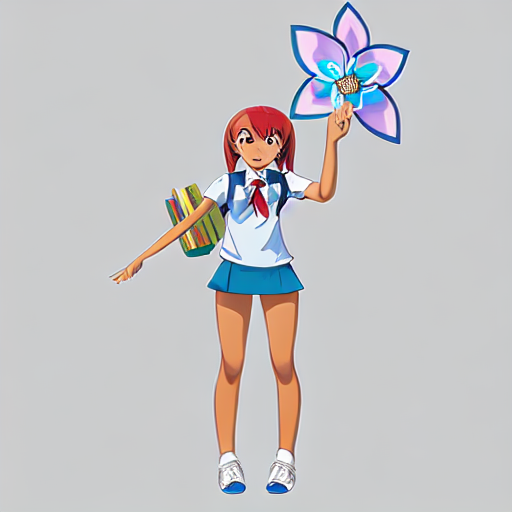

In [108]:
import requests
import torch
from PIL import Image
from io import BytesIO

from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda"
#model_id_or_path = "Christabelle/thesis-concept-art"
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_base, torch_dtype=torch.float16)
pipe.unet.load_attn_procs(model_path)
pipe = pipe.to(device)

url = "https://datasets-server.huggingface.co/assets/Christabelle/AI-Thesis-Sketch-Skeletons/--/Christabelle--AI-Thesis-Sketch-Skeletons/train/6/image/image.png"

response = requests.get(url)
init_image = Image.open(BytesIO(response.content)).convert("RGB")
init_image = init_image.resize((512, 512))

prompt = "a girl in a school uniform, blue hair, wizard, flower motif, fully clothed"

#NSFW checker disabled
pipe.safety_checker = lambda images, **kwargs: (images, [False] * len(images))

images = pipe(prompt=prompt,image=init_image, negative_prompt="monochrome,low res,poorly drawn face, mutated body parts, deformed body features, bad anatomy, worst quality, low quality",strength=0.75, guidance_scale=7.5,num_inference_steps=300).images
images[0].save("img2img_man_trial.png")

for image in images:
    image.show()